In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import random
import seaborn as sns

from pycaret.classification import *
from sklearn.metrics import log_loss

In [3]:
seed = 42
np.random.seed(seed)

In [4]:
train = pd.read_csv('input/train.csv', index_col=['index'])
test = pd.read_csv('input/test.csv', index_col=['index'])
submission = pd.read_csv('input/submission.csv', index_col=['index'])

train.shape, test.shape, submission.shape

((26457, 19), (10000, 18), (10000, 3))

## null 처리 

In [5]:
print(8171/train.shape[0]*100)
#display(train.isna().sum())

print(3152/test.shape[0]*100)
#display(test.isna().sum())

30.884076047926822
31.52


In [6]:
train.drop(['occyp_type'], axis=1, inplace=True)
test.drop(['occyp_type'], axis=1, inplace=True)
train.shape, test.shape

((26457, 18), (10000, 17))

In [7]:
train.FLAG_MOBIL.value_counts(), test.FLAG_MOBIL.value_counts()

train.drop(['FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['FLAG_MOBIL'], axis=1, inplace=True)
train.shape, test.shape

((26457, 17), (10000, 16))

In [8]:
train.loc[train.DAYS_EMPLOYED == 365243, 'DAYS_EMPLOYED'] = 0
test.loc[test.DAYS_EMPLOYED == 365243, 'DAYS_EMPLOYED'] = 0

train['DAYS_EMPLOYED'] = train.DAYS_EMPLOYED*-1
test['DAYS_EMPLOYED'] = test.DAYS_EMPLOYED*-1

train['DAYS_EMPLOYED'] = np.log1p(train.DAYS_EMPLOYED)
test['DAYS_EMPLOYED'] = np.log1p(test.DAYS_EMPLOYED)

In [74]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,cluster
index,,,,,,,,,,,,,,,,,,
0,0,0,0,0,202500.0,0,1,1,2,-13899,8.457443,0,0,0,2.0,-6.0,1.0,14
1,0,0,1,1,247500.0,0,4,0,1,-11380,7.340187,0,0,1,3.0,-5.0,1.0,18
2,1,1,1,0,450000.0,4,1,1,1,-19087,8.397283,0,1,0,2.0,-22.0,2.0,15
3,0,0,1,0,202500.0,0,4,1,1,-15088,7.646354,0,1,0,2.0,-37.0,0.0,14
4,0,1,1,0,157500.0,2,1,1,1,-15037,7.652546,0,0,0,2.0,-26.0,2.0,11


In [10]:
from sklearn.cluster import KMeans

In [72]:
kmeans = KMeans(n_clusters=21, init='k-means++', max_iter=300,random_state=seed)
train['cluster'] = kmeans.fit_predict(train[['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'family_size']])

In [73]:
kmeans = KMeans(n_clusters=21, init='k-means++', max_iter=300,random_state=seed)
test['cluster'] = kmeans.fit_predict(test[['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'family_size']])

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [22]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [24]:
X = train[['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'family_size']]

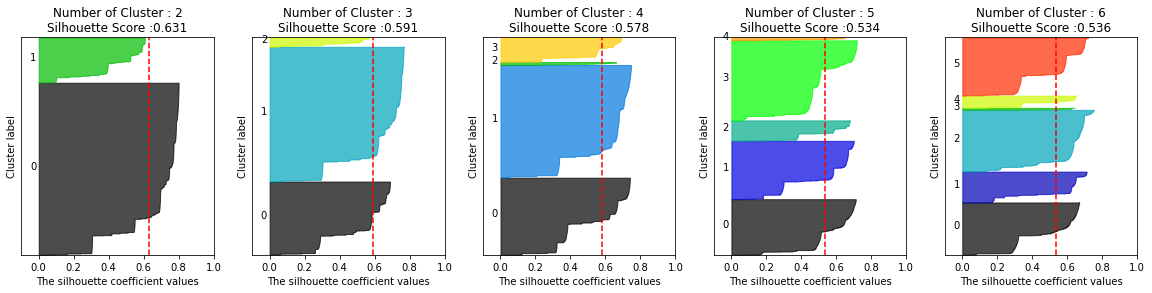

In [27]:
visualize_silhouette([ 2, 3, 4, 5, 6], X)

In [28]:
for i in [ 2, 3, 4, 5, 6]:
    clusterer = KMeans(n_clusters=i, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.630943086120641
For n_clusters = 3 The average silhouette_score is : 0.5834908143639999
For n_clusters = 4 The average silhouette_score is : 0.5597327546080357
For n_clusters = 5 The average silhouette_score is : 0.5506258547071466
For n_clusters = 6 The average silhouette_score is : 0.541013437339885


In [29]:
for i in range(6, 10):
    clusterer = KMeans(n_clusters=i, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 6 The average silhouette_score is : 0.541013437339885
For n_clusters = 7 The average silhouette_score is : 0.5438279191136765
For n_clusters = 8 The average silhouette_score is : 0.5649481352858616
For n_clusters = 9 The average silhouette_score is : 0.5652361610567388


In [30]:
for i in range(10, 15):
    clusterer = KMeans(n_clusters=i, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 10 The average silhouette_score is : 0.5726074128346559
For n_clusters = 11 The average silhouette_score is : 0.5768009441462816
For n_clusters = 12 The average silhouette_score is : 0.5620390675931884
For n_clusters = 13 The average silhouette_score is : 0.5742050874683619
For n_clusters = 14 The average silhouette_score is : 0.5474121929663166


In [66]:
for i in range(15, 20):
    clusterer = KMeans(n_clusters=i, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 15 The average silhouette_score is : 0.5870331719427563
For n_clusters = 16 The average silhouette_score is : 0.6177362885546384
For n_clusters = 17 The average silhouette_score is : 0.6180930108703807
For n_clusters = 18 The average silhouette_score is : 0.6299273649921343
For n_clusters = 19 The average silhouette_score is : 0.644538414841062


In [67]:
for i in range(20, 25):
    clusterer = KMeans(n_clusters=i, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 20 The average silhouette_score is : 0.6531610011942837
For n_clusters = 21 The average silhouette_score is : 0.6497909423108081
For n_clusters = 22 The average silhouette_score is : 0.6470868306039701
For n_clusters = 23 The average silhouette_score is : 0.6471462954752079
For n_clusters = 24 The average silhouette_score is : 0.6149211573299234


In [69]:
for i in range(25, 30):
    clusterer = KMeans(n_clusters=i, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 25 The average silhouette_score is : 0.6518176691512197
For n_clusters = 26 The average silhouette_score is : 0.624127067710416
For n_clusters = 27 The average silhouette_score is : 0.6123095872383061
For n_clusters = 28 The average silhouette_score is : 0.590742312415478
For n_clusters = 29 The average silhouette_score is : 0.5989838126469924


In [70]:
for i in range(30, 35):
    clusterer = KMeans(n_clusters=i, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 30 The average silhouette_score is : 0.5910837229541623
For n_clusters = 31 The average silhouette_score is : 0.5840996295416984
For n_clusters = 32 The average silhouette_score is : 0.5859269449191036
For n_clusters = 33 The average silhouette_score is : 0.5640646039503963
For n_clusters = 34 The average silhouette_score is : 0.5443209976630698


In [86]:
for i in range(1000, 1001):
    clusterer = KMeans(n_clusters=i, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 1000 The average silhouette_score is : 0.6339760684004222


In [ ]:
np.log1p(train.income_total).hist(bins=100)

In [16]:
train['gender'] = train['gender'].replace(['F','M'],[0,1])
train['car'] = train['car'].replace(['N','Y'],[0,1])
train['reality'] = train['reality'].replace(['N','Y'],[0,1])

test['gender'] = test['gender'].replace(['F','M'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])

In [12]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()

In [13]:
train['income_type']=label_encoder.fit_transform(train['income_type'])
train['edu_type']=label_encoder.fit_transform(train['edu_type'])
train['family_type']=label_encoder.fit_transform(train['family_type'])
train['house_type']=label_encoder.fit_transform(train['house_type'])

test['income_type']=label_encoder.fit_transform(test['income_type'])
test['edu_type']=label_encoder.fit_transform(test['edu_type'])
test['family_type']=label_encoder.fit_transform(test['family_type'])
test['house_type']=label_encoder.fit_transform(test['house_type'])

In [ ]:
train.head()

In [ ]:
train.corr()

In [ ]:
sns.heatmap(train.corr())

## 범주형 자료 

In [75]:
col = ['gender','car','reality','phone','email','work_phone'\
      ,'income_type','edu_type','family_type','house_type'\
      #,'child_num','EMPLOYED_YN'
      ]
#train = pd.get_dummies(train, columns=col)
#test = pd.get_dummies(test, columns=col)
#train.shape, test.shape

In [40]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'credit',
       'cluster'],
      dtype='object')

In [76]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'credit'
          , categorical_features=col
          , numeric_features = ['child_num','family_size']#,,'tp17','tp4','Q_A15','Q_A3','Q_A15tp17','Q_A3tp4']#['Q_A1','Q_A3','Q_A5','tp17','tp4','Q_A15tp17','Q_A3tp4']
          #, ignore_features =[]
           )

,Description,Value
0,session_id,42
1,Target,credit
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(26457, 18)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


Wall time: 3.65 s


In [77]:
#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function               <function log_loss at 0x000001A509998798>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

In [78]:
#best5 = compare_models(fold = 5, sort = 'logloss', n_select = 5, exclude=['svm','ridge'])
best_4 = compare_models(sort = 'LogLoss', n_select = 4
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda'\
                                 ,'et','ada','lda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
catboost,CatBoost Classifier,0.7066,0.7111,0.4519,0.6934,0.6449,0.2792,0.3420,0.7603,12.7700
lightgbm,Light Gradient Boosting Machine,0.6996,0.7021,0.4222,0.7061,0.6206,0.2333,0.3204,0.7683,0.3730
gbc,Gradient Boosting Classifier,0.6922,0.6578,0.4079,0.6389,0.6067,0.2061,0.2960,0.7933,3.0430
rf,Random Forest Classifier,0.6990,0.7451,0.5364,0.6772,0.6821,0.3653,0.3719,0.9496,1.7480


In [79]:
blended = blend_models(estimator_list = best_4, fold = 5, optimize = 'logloss')
pred_holdout = predict_model(blended)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.7090,0.7291,0.4468,0.7213,0.6419,0.2728,0.3493,0.7383
1,0.7030,0.7247,0.4357,0.6934,0.6326,0.2568,0.3299,0.7469
2,0.7057,0.7502,0.4399,0.6990,0.6364,0.2636,0.3398,0.7358
3,0.7095,0.7416,0.4456,0.7055,0.6419,0.2748,0.3520,0.7377
4,0.7029,0.7379,0.4364,0.6987,0.6330,0.2576,0.3291,0.7353
Mean,0.7060,0.7367,0.4409,0.7036,0.6372,0.2651,0.3400,0.7388
SD,0.0028,0.0090,0.0046,0.0097,0.0041,0.0075,0.0095,0.0042


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,Voting Classifier,0.7007,0.7498,0.4411,0.6908,0.6305,0.2654,0.3406,0.7366


In [80]:
final_model = finalize_model(blended)

In [81]:
predictions = predict_model(final_model, data = test)

In [82]:
prep_pipe = get_config("prep_pipe")
prep_pipe.steps.append(['trained_model', final_model])
prections = prep_pipe.predict_proba(test)
prections

array([[0.0779163 , 0.14027847, 0.78180523],
       [0.23017601, 0.14486798, 0.624956  ],
       [0.08696058, 0.10894919, 0.80409023],
       ...,
       [0.04574368, 0.08647716, 0.86777917],
       [0.12292607, 0.18732745, 0.68974648],
       [0.08815358, 0.22949836, 0.68234806]])

In [83]:
submission['0'] = prections[:,0]
submission['1'] = prections[:,1]
submission['2'] = prections[:,2]
submission

,0,1,2
index,,,
26457,0.077916,0.140278,0.781805
26458,0.230176,0.144868,0.624956
26459,0.086961,0.108949,0.804090
26460,0.137532,0.112610,0.749858
26461,0.112841,0.208258,0.678901
...,...,...,...
36452,0.157048,0.216153,0.626799
36453,0.121662,0.305104,0.573234
36454,0.045744,0.086477,0.867779


In [85]:
submission.to_csv('output/20210408-3.csv')

from gtts import gTTS
text ="Finish Finish Finish Finish Finish Finish Finish Finish"

tts = gTTS(text=text, lang='en')
tts.save("helloEN.mp3")

In [84]:
from IPython.display import Audio
sound_file = 'helloEN.mp3'

Audio(sound_file, autoplay=True)